# Problem
            จงออกแบบและทำการทดลอง Minimum Risk Bayes Decision Theoretic Classifier ทุก function ควรจะถูกออกแบบให้ independent ต่อกัน สำหรับการบ้านนี้ให้สมมุตว่า ทุก conditional density function เป็น multivariate normal และสามารถ estimate แต่ละ parameter โดยใช้วิธี Maximum Likelihood
            สำหรับ data set นี้ ควรตั้งให้ loss function เป็น 0-1 loss function เพื่อที่ จะได้ “best average classification” และสามารถที่จะตั้งสมมุติฐานได้ว่าแต่ละ class มี a priori probability ที่ เท่ากัน (แต่ไม่ควรที่จะ hard coded)
            ให้ใช้ 10% cross validation และทำการทดสอบ algorithm กับ TWOCLASS data set แต่ละ pass ควรจะมี Output ดังนี้
            1. Mean vectors และ Covariance matrices
            2. Confusion matrix
            3. Error estimates
            4. Classification information ใน test vectors
            และสำหรับ  data set ทั้งชุด ให้หา mean vectors และ Covariance matrices (actual training data).
            ให้ทำการทดลองโดยใช้ทั้ง 4 features และใช้เพียง features ที่ 1 และ 2 จากการทดลองทั้งหมดจะสรุปผลการทดลองได้อย่างไร

Data example:
>f1                   f2                    f3                 f4        class label

```5.91             3.09              3.74             1.17             1
6.94	2.39	3.95	1.02	1
5.73	2.75	4.64	1.02	1
6.14	3.32	3.67	1.24	1
5.42	2.93	3.85	1.37	1
5.03	2.84	3.49	1.02	1

In [16]:
file_path = "TWOCLASS.dat"

try:
    with open(file_path, "r") as file:
        content = file.read()
        data = content.split()
        # print(data)
except FileNotFoundError:
    print("File not found!")

column = ['f1', 'f2', 'f3', 'f4', 'class label']

# drop the first 6 elements from list 'data'
data = data[6:]

In [17]:
data_processed = []

for i in range(0, len(data), 5):
    data_processed.append([float(data[i]), float(data[i+1]), float(data[i+2]), \
                           float(data[i+3]), int(data[i+4])])

# print length of data
print("Length of data: ", len(data_processed))

Length of data:  200


# Explore the data

In [18]:
import matplotlib.pyplot as plt

In [19]:
# create lists for each column of data
f1 = []
f2 = []
f3 = []
f4 = []

for i in range(len(data_processed)):
    f1.append(data_processed[i][0])
    f2.append(data_processed[i][1])
    f3.append(data_processed[i][2])
    f4.append(data_processed[i][3])
    

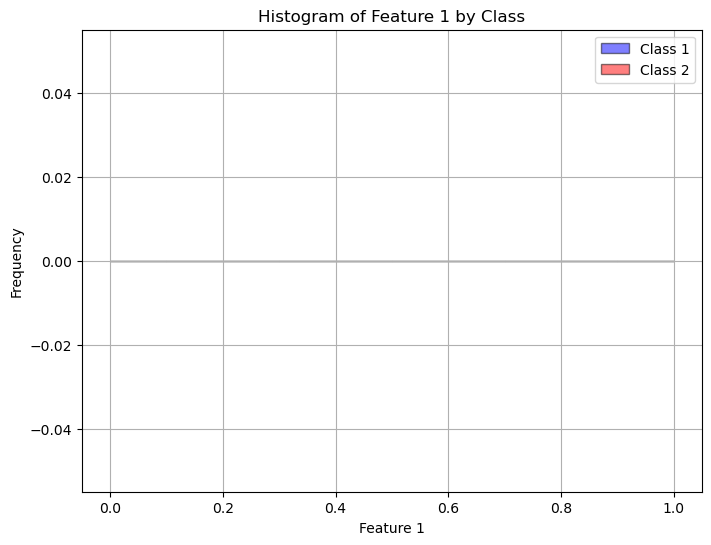

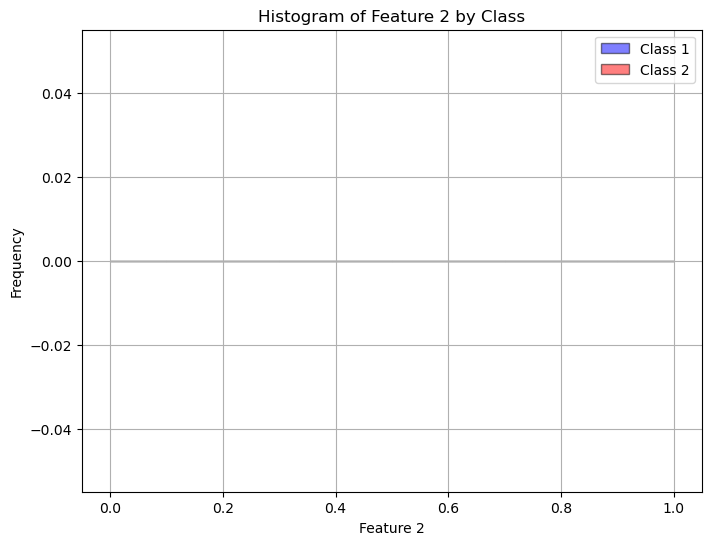

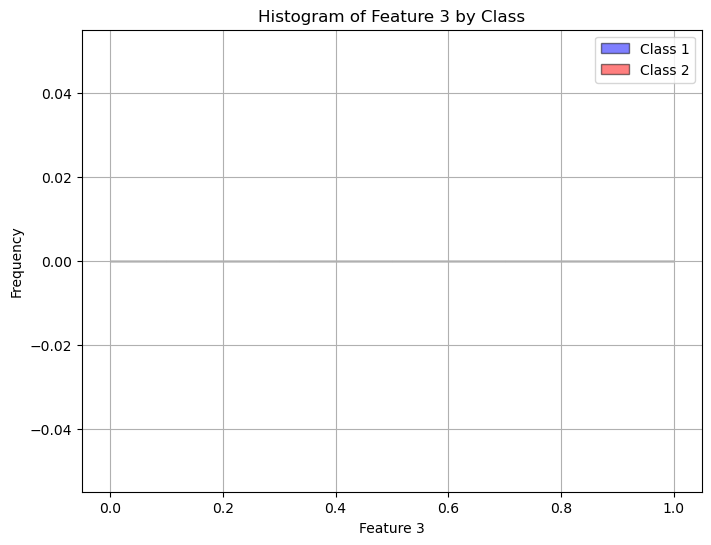

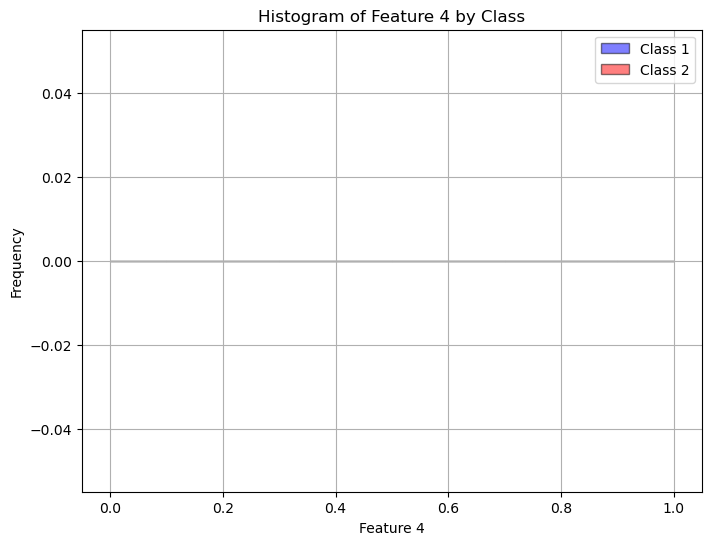

In [20]:
# plot the histograms of each feature, separately for both 2 classes.

# Separate data by class
class1_data = [sample[:-1] for sample in data if sample[-1] == 1]
class2_data = [sample[:-1] for sample in data if sample[-1] == 2]

# Features (replace these labels with your actual feature names)
feature_labels = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4']

# Plot histograms for each feature
num_features = len(feature_labels)
for i in range(num_features):
    plt.figure(figsize=(8, 6))
    plt.hist([x[i] for x in class1_data], bins=10, alpha=0.5, color='blue', label='Class 1', edgecolor='black')
    plt.hist([x[i] for x in class2_data], bins=10, alpha=0.5, color='red', label='Class 2', edgecolor='black')
    plt.xlabel(feature_labels[i])
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature_labels[i]} by Class')
    plt.legend()
    plt.grid(True)
    plt.show()



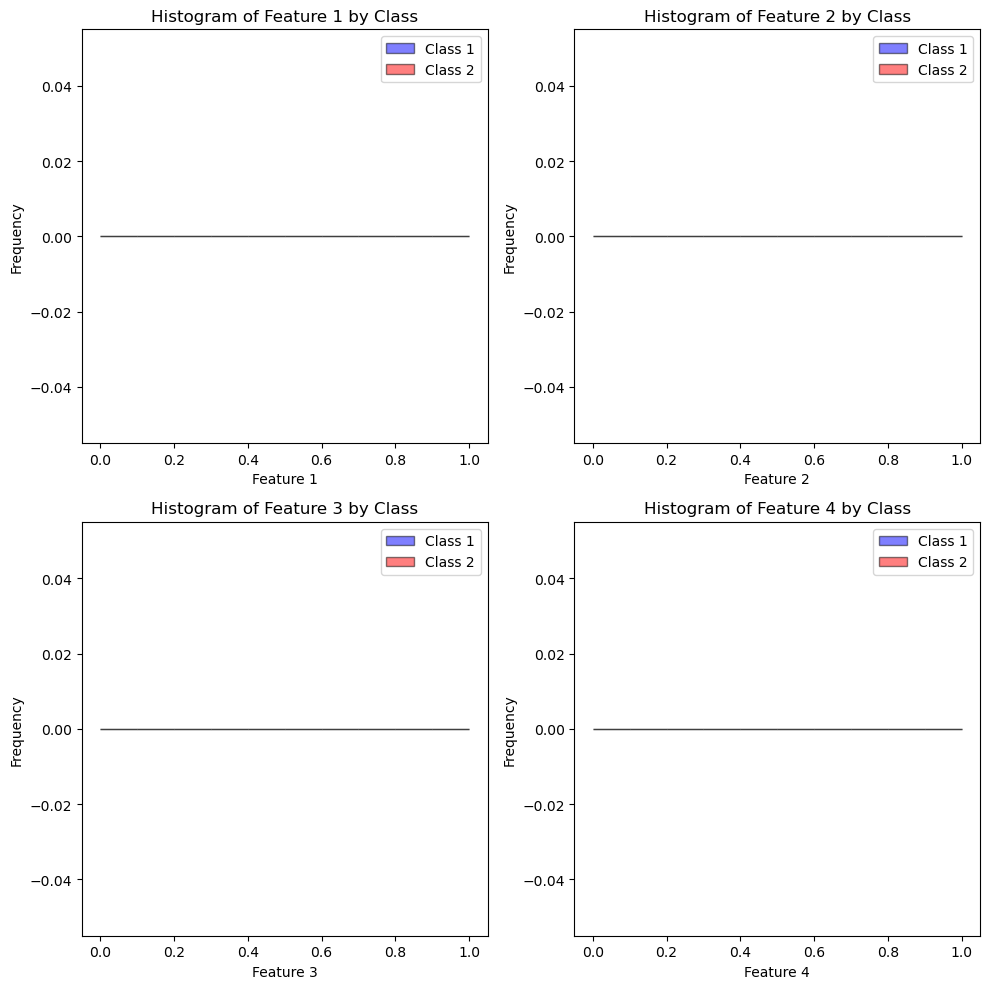

In [21]:
# Features (replace these labels with your actual feature names)
feature_labels = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4']

# Create a subplot of 2x2 graphs, each with a size of 10x10
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot histograms for each feature
for i in range(len(feature_labels)):
    ax = axs[i // 2, i % 2]  # Get the appropriate subplot
    ax.hist([x[i] for x in class1_data], bins=10, alpha=0.5, color='blue', label='Class 1', edgecolor='black')
    ax.hist([x[i] for x in class2_data], bins=10, alpha=0.5, color='red', label='Class 2', edgecolor='black')
    ax.set_xlabel(feature_labels[i])
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {feature_labels[i]} by Class')
    ax.legend()
    # ax.grid(True)

plt.tight_layout()
plt.show()

# Minimum Risk Bayes Decision Theoretic Classifier
## Using 4 features

In [22]:
# need to use numpy because of the log function and matrix operation, otherwise it will error.
import numpy as np 

print('Using all 4 features')
# Step 1: Estimate Parameters (Mean vectors and Covariance matrices)
def estimate_parameters(data):
    num_features = len(data[0]) - 1  # Exclude the last column (class label)
    num_classes = max(data, key=lambda x: x[-1])[-1]  # Assuming class labels are 1-indexed

    mean_vectors = {i: np.zeros(num_features) for i in range(1, num_classes + 1)}
    covariance_matrices = {i: np.zeros((num_features, num_features)) for i in range(1, num_classes + 1)}
    class_counts = {i: 0 for i in range(1, num_classes + 1)}

    # Calculate the sum of feature values for each class
    for row in data:
        class_label = int(row[-1])
        class_counts[class_label] += 1
        for i in range(num_features):
            mean_vectors[class_label][i] += row[i]

    # Calculate the mean vectors
    for class_label in mean_vectors:
        mean_vectors[class_label] /= class_counts[class_label]

    # Calculate the covariance matrices
    for row in data:
        class_label = int(row[-1])
        x_minus_mean = row[:-1] - mean_vectors[class_label]
        x_minus_mean = x_minus_mean.reshape((-1, 1))  # Convert to column vector
        covariance_matrices[class_label] += np.dot(x_minus_mean, x_minus_mean.T)

    for class_label in covariance_matrices:
        covariance_matrices[class_label] /= (class_counts[class_label] - 1)

    return mean_vectors, covariance_matrices

# Step 2: Minimum Risk Bayes Decision Theoretic Classifier
def multivariate_normal_pdf(x, mean, covariance):
    k = len(x)
    coefficient = 1.0 / ((2 * np.pi) ** (k / 2) * np.linalg.det(covariance))

    x_minus_mean = x - mean

    # Calculate the Mahalanobis distance squared
    mahalanobis_dist_sq = np.dot(x_minus_mean, np.linalg.solve(covariance, x_minus_mean))

    # Calculate the exponent without using math.exp
    exponent = -0.5 * mahalanobis_dist_sq

    return coefficient * np.exp(exponent)

def minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities):
    num_classes = len(mean_vectors)
    log_likelihoods = np.zeros(num_classes)

    for class_label in range(1, num_classes + 1):
        mean_vector = np.array(mean_vectors[class_label])
        covariance_matrix = np.array(covariance_matrices[class_label])

        # Convert the test_sample to a NumPy array
        test_sample_arr = np.array(test_sample)

        # Calculate (x - mean)
        x_minus_mean = test_sample_arr - mean_vector

        # Calculate the determinant of the covariance matrix
        det_covariance = np.linalg.det(covariance_matrix)

        # Calculate the inverse of the covariance matrix
        inv_covariance = np.linalg.inv(covariance_matrix)

        # Calculate the Mahalanobis distance squared
        mahalanobis_dist_sq = np.dot(x_minus_mean, np.dot(inv_covariance, x_minus_mean))

        # Calculate the log-likelihood
        log_likelihood = -0.5 * (mahalanobis_dist_sq + np.log(det_covariance))

        # Calculate the log-likelihood with the prior probability
        log_likelihood += np.log(prior_probabilities[class_label])

        log_likelihoods[class_label - 1] = log_likelihood

    # Choose the class with the highest log-likelihood as the predicted label
    predicted_label = np.argmax(log_likelihoods) + 1

    return predicted_label

# Step 3: 10% Cross Validation
def cross_validation(data):
    num_samples_per_class = len(data) // 2
    fold_size = num_samples_per_class // 10  # Each fold will have 10 samples per class
    total_samples = len(data)
    total_misclassifications = 0
    predicted_labels = []  # List to store the predicted labels for all test samples

    for i in range(10):
        start_idx_class1 = i * fold_size
        end_idx_class1 = (i + 1) * fold_size
        start_idx_class2 = num_samples_per_class + start_idx_class1
        end_idx_class2 = num_samples_per_class + end_idx_class1

        test_set = data[start_idx_class1:end_idx_class1] + data[start_idx_class2:end_idx_class2]
        train_set = data[:start_idx_class1] + data[end_idx_class1:start_idx_class2] + data[end_idx_class2:]

        mean_vectors, covariance_matrices = estimate_parameters(train_set)

        misclassifications = 0
        fold_predicted_labels = []  # List to store the predicted labels for the current fold

        print(f"\nFold {i+1} Results:")
        for sample in test_set:
            test_sample = sample[:-1]  # Exclude the class label from the test sample
            true_label = int(sample[-1])
            predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
            fold_predicted_labels.append(predicted_label)  # Store the predicted label for the current sample

            if predicted_label != true_label:
                misclassifications += 1

            # Display classification information for the current test sample
            print(f"Fold {i+1} - True Label: {true_label}, Predicted Label: {predicted_label}")

        predicted_labels.extend(fold_predicted_labels)  # Add the predicted labels for the current fold to the list
        fold_accuracy = 1 - (misclassifications / (2 * fold_size))
        total_misclassifications += misclassifications

        # Display results for the current fold
        print(f"Accuracy: {fold_accuracy:.2f}")
        print(f"Misclassifications: {misclassifications}/{2 * fold_size}")

        confusion_matrix = [[0, 0], [0, 0]]
        for true_label, predicted_label in zip([1] * fold_size + [2] * fold_size, fold_predicted_labels):
            confusion_matrix[true_label - 1][predicted_label - 1] += 1

        display_results(mean_vectors, covariance_matrices, confusion_matrix)

    overall_accuracy = 1 - (total_misclassifications / total_samples)
    print("\nOverall Results:")
    print(f"Overall Accuracy: {overall_accuracy:.2f}")
    print(f"Overall Misclassifications: {total_misclassifications}/{total_samples}")

    avg_accuracy = 1 - (total_misclassifications / total_samples)
    return avg_accuracy, predicted_labels

# Step 4: Display Results (Mean vectors, Covariance matrices, Confusion matrix, Error estimates, Classification information)
def display_results(mean_vectors, covariance_matrices, confusion_matrix):
    print("Mean Vectors:")
    for class_label, mean_vector in mean_vectors.items():
        print(f"Class {class_label}: {mean_vector}")

    print("\nCovariance Matrices:")
    for class_label, covariance_matrix in covariance_matrices.items():
        print(f"Class {class_label}:")
        for row in covariance_matrix:
            print(row)

    print("\nConfusion Matrix:")
    for row in confusion_matrix:
        print(row)

    total_samples = sum(sum(row) for row in confusion_matrix)
    correct_predictions = sum(confusion_matrix[i][i] for i in range(len(confusion_matrix)))
    error_rate = (total_samples - correct_predictions) / total_samples
    print(f"\nError Rate: {error_rate:.2f}")
    print('\n----------------------------------------')

# Step 5: Main code
# Example data
data = data_processed

# Assuming equal prior probabilities for each class (not hard-coded)
num_classes = max(data, key=lambda x: x[-1])[-1]
prior_probabilities = {i: 1 / num_classes for i in range(1, num_classes + 1)}

# Perform cross-validation and display the results
avg_accuracy, predicted_labels = cross_validation(data)
print(f"\nAverage Accuracy: {avg_accuracy:.2f}")

# Estimate mean vectors and covariance matrices using the entire data
mean_vectors, covariance_matrices = estimate_parameters(data)

# Calculate confusion matrix using the entire data
confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
for sample in data:
    true_label = int(sample[-1])
    test_sample = sample[:-1]
    predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
    confusion_matrix[true_label - 1][predicted_label - 1] += 1

print("\nOverall Results:")
print("Mean Vectors:")
for class_label, mean_vector in mean_vectors.items():
    print(f"Class {class_label}: {mean_vector}")

print("\nCovariance Matrices:")
for class_label, covariance_matrix in covariance_matrices.items():
    print(f"Class {class_label}:")
    for row in covariance_matrix:
        print(row)

print("\nConfusion Matrix:")
for row in confusion_matrix:
    print(row)

total_samples = sum(sum(row) for row in confusion_matrix)
correct_predictions = sum(confusion_matrix[i][i] for i in range(len(confusion_matrix)))
error_rate = (total_samples - correct_predictions) / total_samples
print(f"\nError Rate: {error_rate:.2f}")

Using all 4 features

Fold 1 Results:
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Accuracy: 1.00
Misclassifications: 0/20
Mean Vectors:
Class 1: [6.381      2.914      4.23811111 1.301

## Using features 1 & 2 

In [24]:
import numpy as np

print('Using features 1 and 2')
# Step 1: Estimate Parameters (Mean vectors and Covariance matrices)
def estimate_parameters(data):
    num_features = 2  # Considering only features 1 and 2
    num_classes = max(data, key=lambda x: x[-1])[-1]  # Assuming class labels are 1-indexed

    mean_vectors = {i: np.zeros(num_features) for i in range(1, num_classes + 1)}
    covariance_matrices = {i: np.zeros((num_features, num_features)) for i in range(1, num_classes + 1)}
    class_counts = {i: 0 for i in range(1, num_classes + 1)}

    # Calculate the sum of feature values for each class
    for row in data:
        class_label = int(row[-1])
        class_counts[class_label] += 1
        for i in range(num_features):
            mean_vectors[class_label][i] += row[i]

    # Calculate the mean vectors
    for class_label in mean_vectors:
        mean_vectors[class_label] /= class_counts[class_label]

    # Calculate the covariance matrices
    for row in data:
        class_label = int(row[-1])
        x_minus_mean = row[:num_features] - mean_vectors[class_label]
        x_minus_mean = x_minus_mean.reshape((-1, 1))  # Convert to column vector
        covariance_matrices[class_label] += np.dot(x_minus_mean, x_minus_mean.T)

    for class_label in covariance_matrices:
        covariance_matrices[class_label] /= (class_counts[class_label] - 1)

    return mean_vectors, covariance_matrices

# Step 2: Minimum Risk Bayes Decision Theoretic Classifier
def minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities):
    num_classes = len(mean_vectors)
    log_likelihoods = np.zeros(num_classes)

    for class_label in range(1, num_classes + 1):
        mean_vector = np.array(mean_vectors[class_label])
        covariance_matrix = np.array(covariance_matrices[class_label])

        # Convert the test_sample to a NumPy array and select only features 1 and 2
        test_sample_arr = np.array(test_sample)[:2]

        # Calculate (x - mean) for the selected features
        x_minus_mean = test_sample_arr - mean_vector[:2]

        # Calculate the determinant of the covariance matrix for the selected features
        det_covariance = np.linalg.det(covariance_matrix[:2, :2])

        # Calculate the inverse of the covariance matrix for the selected features
        inv_covariance = np.linalg.inv(covariance_matrix[:2, :2])

        # Calculate the Mahalanobis distance squared for the selected features
        mahalanobis_dist_sq = np.dot(x_minus_mean, np.dot(inv_covariance, x_minus_mean))

        # Calculate the log-likelihood for the selected features
        log_likelihood = -0.5 * (mahalanobis_dist_sq + np.log(det_covariance))

        # Calculate the log-likelihood with the prior probability
        log_likelihood += np.log(prior_probabilities[class_label])

        log_likelihoods[class_label - 1] = log_likelihood

    # Choose the class with the highest log-likelihood as the predicted label
    predicted_label = np.argmax(log_likelihoods) + 1

    return predicted_label

# Step 3: 10% Cross Validation
def cross_validation(data):
    num_samples_per_class = len(data) // 2
    fold_size = num_samples_per_class // 10  # Each fold will have 10 samples per class
    total_samples = len(data)
    total_misclassifications = 0
    predicted_labels = []  # List to store the predicted labels for all test samples

    for i in range(10):
        start_idx_class1 = i * fold_size
        end_idx_class1 = (i + 1) * fold_size
        start_idx_class2 = num_samples_per_class + start_idx_class1
        end_idx_class2 = num_samples_per_class + end_idx_class1

        test_set = data[start_idx_class1:end_idx_class1] + data[start_idx_class2:end_idx_class2]
        train_set = data[:start_idx_class1] + data[end_idx_class1:start_idx_class2] + data[end_idx_class2:]

        mean_vectors, covariance_matrices = estimate_parameters(train_set)

        misclassifications = 0
        fold_predicted_labels = []  # List to store the predicted labels for the current fold

        print(f"\nFold {i+1} Results:")
        for sample in test_set:
            test_sample = sample[:-1]  # Exclude the class label from the test sample
            true_label = int(sample[-1])
            predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
            fold_predicted_labels.append(predicted_label)  # Store the predicted label for the current sample

            if predicted_label != true_label:
                misclassifications += 1

            # Display classification information for the current test sample
            print(f"Fold {i+1} - True Label: {true_label}, Predicted Label: {predicted_label}")

        predicted_labels.extend(fold_predicted_labels)  # Add the predicted labels for the current fold to the list
        fold_accuracy = 1 - (misclassifications / (2 * fold_size))
        total_misclassifications += misclassifications

        # Display results for the current fold
        print(f"Accuracy: {fold_accuracy:.2f}")
        print(f"Misclassifications: {misclassifications}/{2 * fold_size}")

        confusion_matrix = [[0, 0], [0, 0]]
        for true_label, predicted_label in zip([1] * fold_size + [2] * fold_size, fold_predicted_labels):
            confusion_matrix[true_label - 1][predicted_label - 1] += 1

        display_results(mean_vectors, covariance_matrices, confusion_matrix)

    overall_accuracy = 1 - (total_misclassifications / total_samples)
    print("\nOverall Results:")
    print(f"Overall Accuracy: {overall_accuracy:.2f}")
    print(f"Overall Misclassifications: {total_misclassifications}/{total_samples}")

    avg_accuracy = 1 - (total_misclassifications / total_samples)
    return avg_accuracy, predicted_labels

# Step 4: Display Results (Mean vectors, Covariance matrices, Confusion matrix, Error estimates, Classification information)
def display_results(mean_vectors, covariance_matrices, confusion_matrix):
    print("Mean Vectors:")
    for class_label, mean_vector in mean_vectors.items():
        print(f"Class {class_label}: {mean_vector}")

    print("\nCovariance Matrices:")
    for class_label, covariance_matrix in covariance_matrices.items():
        print(f"Class {class_label}:")
        for row in covariance_matrix:
            print(row)

    print("\nConfusion Matrix:")
    for row in confusion_matrix:
        print(row)

    total_samples = sum(sum(row) for row in confusion_matrix)
    correct_predictions = sum(confusion_matrix[i][i] for i in range(len(confusion_matrix)))
    error_rate = (total_samples - correct_predictions) / total_samples
    print(f"\nError Rate: {error_rate:.2f}")
    print('\n----------------------------------------')

# Step 5: Main code
# Example data
data = data_processed

# Assuming equal prior probabilities for each class (not hard-coded)
num_classes = max(data, key=lambda x: x[-1])[-1]
prior_probabilities = {i: 1 / num_classes for i in range(1, num_classes + 1)}

# Perform cross-validation and display the results
avg_accuracy, predicted_labels = cross_validation(data)
print(f"\nAverage Accuracy: {avg_accuracy:.2f}")

# Estimate mean vectors and covariance matrices using the entire data
mean_vectors, covariance_matrices = estimate_parameters(data)

# Calculate confusion matrix using the entire data
confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
for sample in data:
    true_label = int(sample[-1])
    test_sample = sample[:-1]
    predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
    confusion_matrix[true_label - 1][predicted_label - 1] += 1

print("\nOverall Results:")
print("Mean Vectors:")
for class_label, mean_vector in mean_vectors.items():
    print(f"Class {class_label}: {mean_vector}")

print("\nCovariance Matrices:")
for class_label, covariance_matrix in covariance_matrices.items():
    print(f"Class {class_label}:")
    for row in covariance_matrix:
        print(row)

print("\nConfusion Matrix:")
for row in confusion_matrix:
    print(row)

total_samples = sum(sum(row) for row in confusion_matrix)
correct_predictions = sum(confusion_matrix[i][i] for i in range(len(confusion_matrix)))
error_rate = (total_samples - correct_predictions) / total_samples
print(f"\nError Rate: {error_rate:.2f}")


Using features 1 and 2

Fold 1 Results:
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 2
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 2
Fold 1 - True Label: 1, Predicted Label: 1
Fold 1 - True Label: 1, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 1
Fold 1 - True Label: 2, Predicted Label: 2
Fold 1 - True Label: 2, Predicted Label: 2
Accuracy: 0.50
Misclassifications: 10/20
Mean Vectors:
Class 1: [6.381 2.914]
Class 2: [6.61466667 2